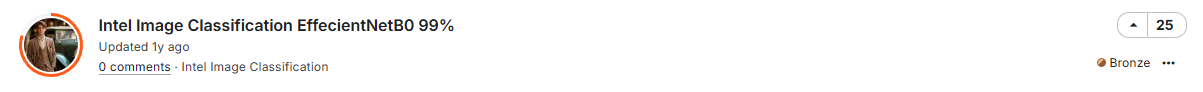

In [1]:
#os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#Deep learnings tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = 'D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_train\seg_train'
test_data = 'D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_test\seg_test'

filepath= []
label =[]

folds = os.listdir(train_data)

for fold in folds:
    f_path = os.path.join(train_data , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
train_df = pd.concat([fseries , lseries] , axis = 1)

In [7]:
train_df

,filepaths,labels
0,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
1,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
2,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
3,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
4,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
...,...,...
14029,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
14030,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
14031,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
14032,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street


In [4]:
folds = os.listdir(test_data)

for fold in folds:
    f_path = os.path.join(test_data , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
ts_df = pd.concat([fseries , lseries] , axis = 1)

In [6]:
ts_df

,filepaths,labels
0,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
1,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
2,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
3,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
4,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
...,...,...
17029,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
17030,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
17031,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
17032,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street


In [10]:
valid , test = train_test_split(ts_df , test_size= 0.5 , shuffle = True , random_state = 42)
print(f"Shape of Validation set is: {valid.shape}")
print(f"Shape of Test set is: {test.shape}")

Shape of Validation set is: (8517, 2)
Shape of Test set is: (8517, 2)


In [11]:
img_size = (150 ,150)
batch_size = 32

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 14034 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.


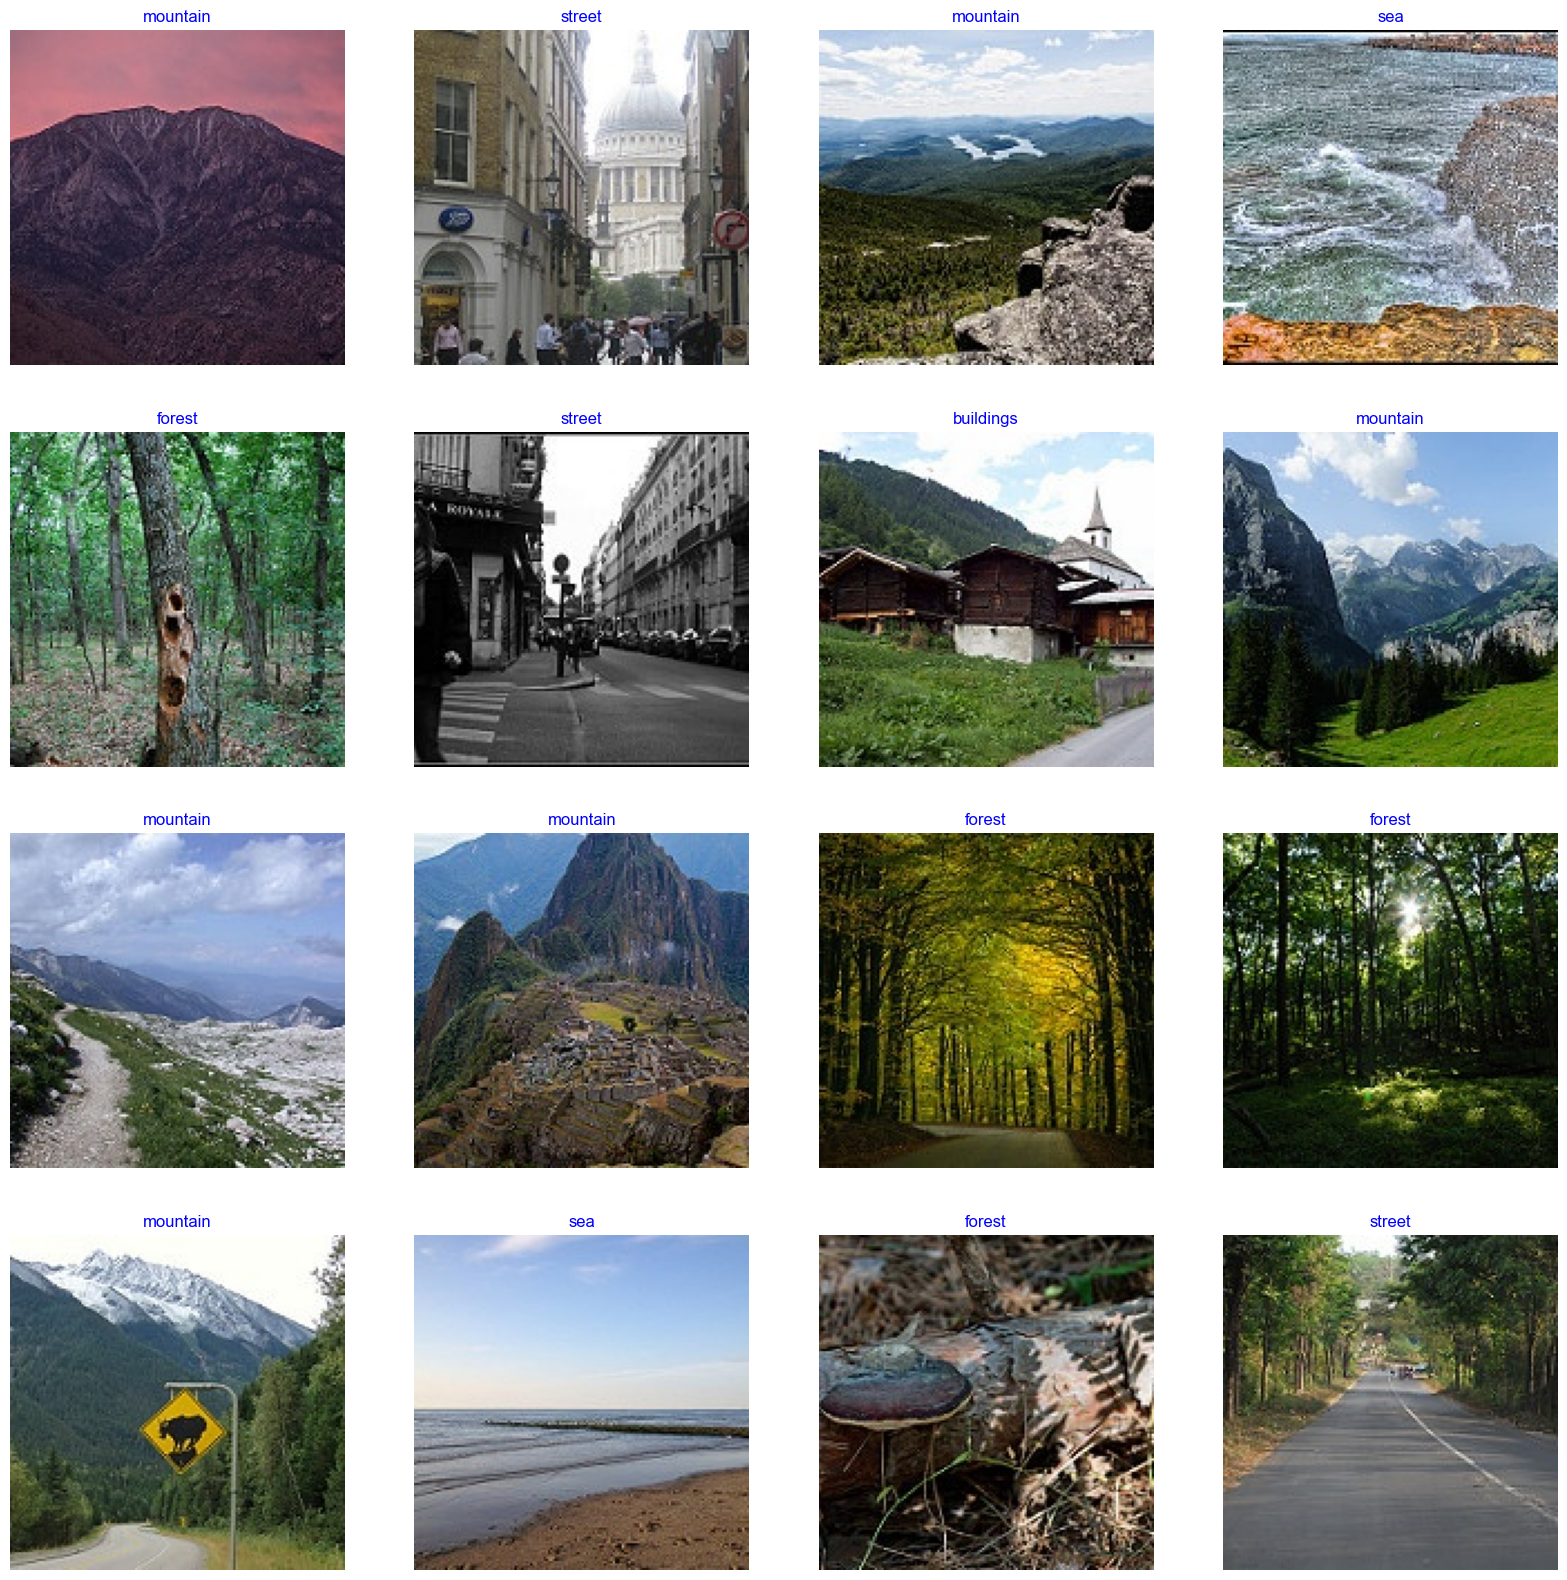

In [12]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [13]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 4,449,961
Trainable params: 4,405,378
Non-trainable params: 44,583
_________________________________________________________________


In [15]:
epochs = 10

history = model.fit(x = train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False , workers=5)

Epoch 1/10
163/439 [==========>...................] - ETA: 46s - loss: 0.2378 - accuracy: 0.9225